In [1]:
# Import required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import style
from summarytools import dfSummary # to help summarize our data
import warnings # to remove all the warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans # importing the K means cluster library
from sklearn.metrics import silhouette_score # importing a metric for our clusters
from sklearn.decomposition import PCA # importing PCA for dimentionality reduction

In [2]:
wine_data = pd.read_csv('winequality-red.csv')
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
dfSummary(wine_data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,fixed acidity[float64],Mean (sd) : 8.3 (1.7)min < med < max:4.6 < 7.9 < 15.9IQR (CV) : 2.1 (4.8),96 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACnUlEQVR4nO3du47aQBSA4TOwIHORLUQEHU3KSCkoeYg8bB4hSDwBbSo6JAsZ4WBhjFNtmrBcxuNljvV//SxT/LJ2ZB+NKctSAN+1Xr0B4BFvr97ALcaYnoh0LZefyrI8utwPXsfbUI0xvfF4/CMMw5HN+v1+vzPG/CTWZvA2VBHphmE4WiwWxyiKsmcWJkkSrFarURzHXREh1AbwOVQREYmiKJtMJn8slvacbwYvw2EKKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqeP+Fv62iKDoiEhpjbP8Ew4EeaWSoaZp28jz/PpvN2u12+6l5q3cMB/qlkaGeTqe3IAj68/k8m06nu2fXMxzon0aG+m4wGNgOBoowHOgVDlNQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSrU+plfxet3wsvl0nG5H+hVW6hVr9/J8zwoiuJblmW/RMT2m1I0RJ1PVOvrd0RENpvNaL1e98/nc7uOzUGX2r/wt71+Z7fb8YU9/uEwBRUaPTNVRcVxa0atHSPUK6qOWzNq7R6hXlFl3JpR63oQ6g0Vxq05CDrGYQoqECpUIFSoQKhQgVChAqf+GvCywD1CdYyXBfUgVMd4WVAPQq0JLwvc4jAFFXiieoZLMq4jVI9wScbHCNUjXJLxsbuhVpgkZYrUEpdk/O9mqFUmSZkihUv3nqjWk6RMkcKlh/5HtZkkZYr0NZr6+pbDVIM0+fUtoTZI1de3y+VyEsfxF2PM3nILLRG5WK69+TR/KNQkSYJnf/VwOAQiImmaBtvttv+Z67X+tqt92zgej5WexkVRdNI0/TocDn+3Wq382fX3nuZ/AbiTgEtJ+TsoAAAAAElFTkSuQmCC"">",0(0.0%)
2,volatile acidity[float64],Mean (sd) : 0.5 (0.2)min < med < max:0.1 < 0.5 < 1.6IQR (CV) : 0.2 (2.9),143 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACiUlEQVR4nO3dTY6iQBiA4a/GP/wJxJjozgtMMguXHGIOO0dw4Qm8gTsTQzAyzYjArJx0Mj3dQhUjH/0++0IWb+iiinSZsiwFaLsvz74B4BH9Z99AU4wxYxEZWlziWpbli6v7gZ1OhmqMGS8Wi+++78/rXuN8PkfGmB/E2g6dDFVEhr7vz8MwfAmCIK06OI5jb7fbzU+n01BECLUFuhqqiIgEQZAul8ufNYePnd4MrPAyBRUIFSoQKlQgVKjQ6pcpi7VQvyiKgev7wfO0NlSbtdAsy7w8z7+maboVkbpv/WiRRkO13B3yZ7PZMgzDc9W10MPhMN/v95Pb7dar+dtomcZCtd0duj8VR6PRtupaaBRFrIF2TJNPVKvdIZ6KeK3xOWrd3SGeiniN5SmoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVGjtYRPPluf5QER8Y0yd4ZxM7RihviFJkkGWZd/W63Wv1+tV/rfunEztHqG+4Xq99j3Pm2w2m3S1WkVVxnIydTMI9R3T6bTu6dScP+AYL1NQgVChAqFCBUKFCoQKFQgVKhAqVPhwHdXiKHO/KIpBjXHAX94N1eYo8/sx5mmabkWkzqI58MdHT9TaR5lzjDlcemgLtc5R5p/5GHO+vHKPvX7H+PKqGYTqGF9eNYNQG8KXV24RastYzm9FOjrHJdQWsZ3finR3jkuoLWIzvxXp9hz3oVDjOPaqXvhyuXgiIkmSeMfjcfI/x2v97ftYG3me98Vu6vAsv8qy/Odfkd+3nScJ/aVy7AAAAABJRU5ErkJggg=="">",0(0.0%)
3,citric acid[float64],Mean (sd) : 0.3 (0.2)min < med < max:0.0 < 0.3 < 1.0IQR (CV) : 0.3 (1.4),80 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACgUlEQVR4nO3cMY7aQBSA4TdhIQNENogEOlqKSCkoOUQOmyOkoKXhBnRIBhnh4MUYp4gSrRR2wTZe5ln/V+/YFD+7GvvNmizLBHDdh0d/AOAWT9d+wBjTFpFWwesfsyw7FFwL/PNmqMaY9mAw+O55Xr/IxXe73dYY84NYUda136gtz/P6s9ns4Pt+nOfCYRja+XzeD4KgJSKEilKu/ukXEfF9Px4Oh78KXL9dYA3wHzZTUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUKFm971PwojhvjL2VAZMcRLzoYqjBjiBZdDFRFGDPEHmymoQKhQgVChAqFCBUKFCs7v+h+Flw1uIdQLeNngHkK9jJcNjiHUN/CywR1spqACoUIFQoUKhAoVCBUqVLrrT9O0KSKeMabIcu98Pjc13hv3V1moURQ1kyT5Nh6PG41GI9ezSBGRJElsmqZf4zj+KSK5HhE98t6oRmWhHo/HJ2ttZzqdxqPRaJt3/Wq16i+Xy87pdGpoujeqUfkD/263W+ih+Xa7Lf3Q/JH3xn2xmYIKhAoVCBUqECpUIFSoQKhQgVChAqFCBSb8K1ByzoCDgRcQ6p2VnTPgYOBlhHpnZeYMOBj4OkKtSNE5A+Fg4EVspqACoUIFQoUKhAoVCBUqECpUIFSoQKhQgQf+jik5JyBS01kBQnVI2TkBkfrOChCqQ8r+P4I6zwoQqoNKzAmI1HRWgM0UVCBUqECoUIFQoQKbqZqp63ktQq2ROp/XuinUMAxt3gvv93srIhJFkV2v1533XK/13mU/92az+WSt7UwmE9Pr9Z7zrD0cDh8Xi8WXIAg+G2N2ee99B89Zlr365foNRqpjgXEhTmwAAAAASUVORK5CYII="">",0(0.0%)
4,residual sugar[float64],Mean (sd) : 2.5 (1.4)min < med < max:0.9 < 2.2 < 15.5IQR (CV) : 0.7 (1.8),91 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG

In [4]:
wine_data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

> If you remember from my last project, when I removed the (2) duplicated values I lost over 10% accuracy. So I will be performing a comparative analysis of not only using K means cluster for preprocessing, but also removing duplicated values and leaving them on.

In [5]:
no_duplicates = wine_data[wine_data.duplicated() == False]

In [6]:
no_duplicates[no_duplicates.duplicated() == True] # confirming I had removed them all

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


In [7]:
no_duplicates.shape

(1359, 12)

In [8]:
def heatmap(data):
    plt.figure(figsize=(10,7))
    sns.heatmap(data.corr(), annot=True)
    plt.title('Correlation between Features')
    plt.show()

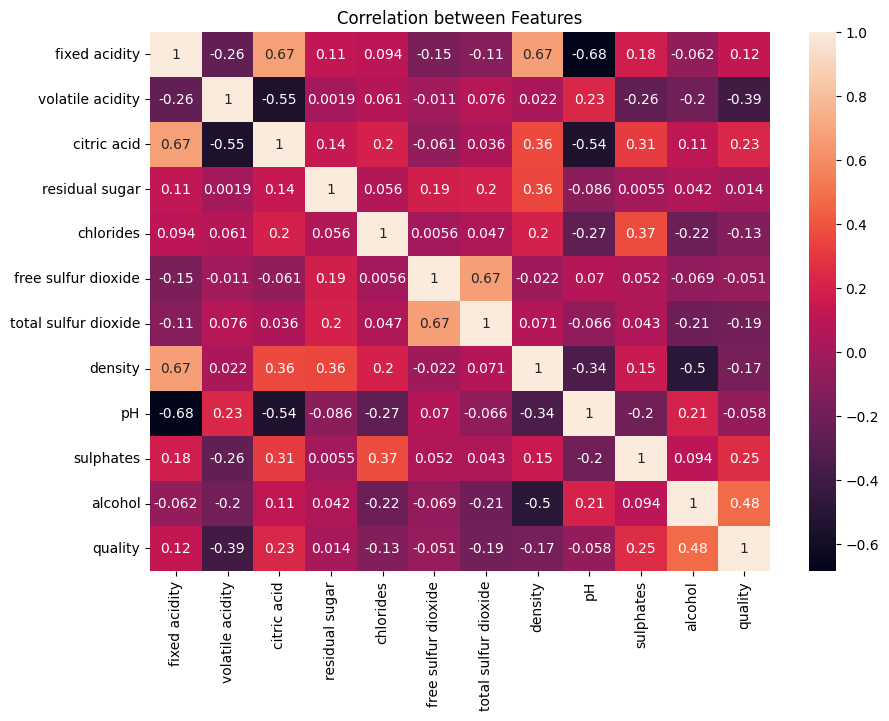

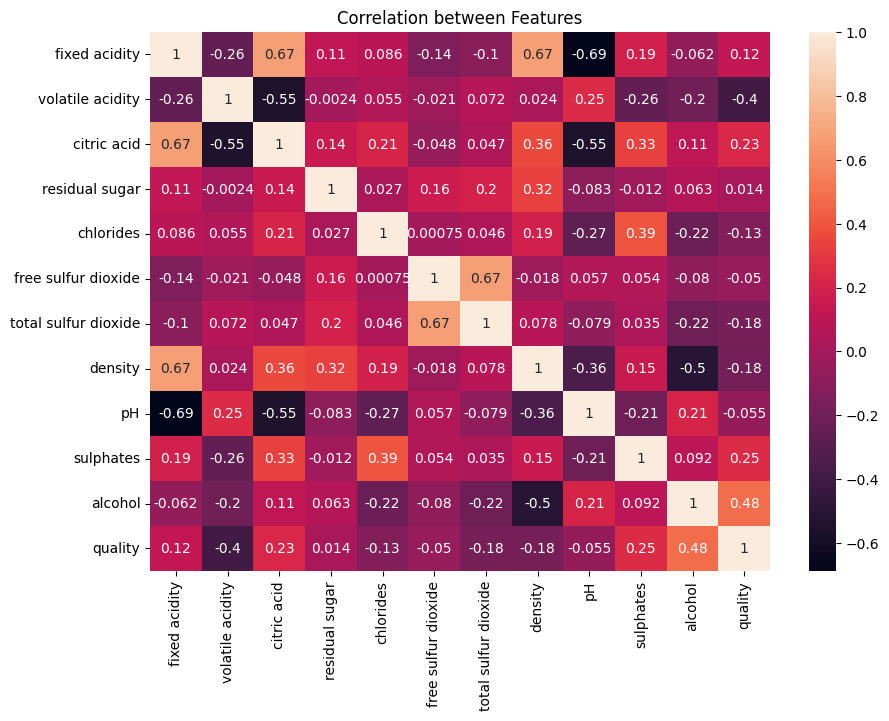

In [9]:
heatmap(wine_data)
heatmap(no_duplicates)

**Inference :**
- The two most prominent features the have a significantly strong relationship with *quality* is *alchohol* with 0.48 and *volatile acidity* with ~(-0.4)
- There doesn't seem to be a significant difference between the two datasets, but I will continue the comparative analysis.

In [26]:
# To see this better
wine_data.corr()['quality'].sort_values()

volatile acidity       -0.390558
total sulfur dioxide   -0.185100
density                -0.174919
chlorides              -0.128907
pH                     -0.057731
free sulfur dioxide    -0.050656
residual sugar          0.013732
fixed acidity           0.124052
citric acid             0.226373
sulphates               0.251397
alcohol                 0.476166
quality                 1.000000
Name: quality, dtype: float64

In [27]:
no_duplicates.corr()['quality'].sort_values()

volatile acidity       -0.395214
density                -0.184252
total sulfur dioxide   -0.177855
chlorides              -0.130988
pH                     -0.055245
free sulfur dioxide    -0.050463
residual sugar          0.013640
fixed acidity           0.119024
citric acid             0.228057
sulphates               0.248835
alcohol                 0.480343
quality                 1.000000
Name: quality, dtype: float64

### Creating our clusters

In [10]:
# We drop the quality column
wine_data_v2 = wine_data.drop('quality', axis=1)
no_duplicates_v2 = no_duplicates.drop('quality', axis=1)

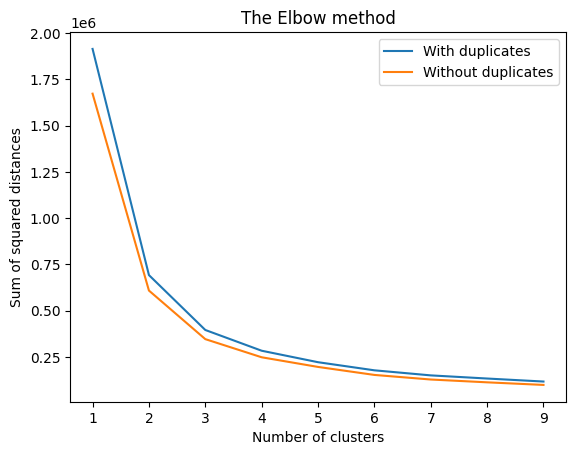

In [11]:
# Elbow method
wss=[]
nd_wss=[]
for i in range(1,10):
    # For the data with duplicates
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42) # go read up on 'init'
    kmeans.fit(wine_data_v2)
    wss.append(kmeans.inertia_) # go read up on 'inertia_'
    
    # For the data without duplicates
    nd_kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42) # go read up on 'init'
    nd_kmeans.fit(no_duplicates_v2)
    nd_wss.append(nd_kmeans.inertia_) # go read up on 'inertia_'

plt.plot(range(1,10), wss, label="With duplicates")
plt.plot(range(1,10), nd_wss, label="Without duplicates")
plt.title('The Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.legend()
plt.show()

To interprete this well, we use the KElbow visualizer

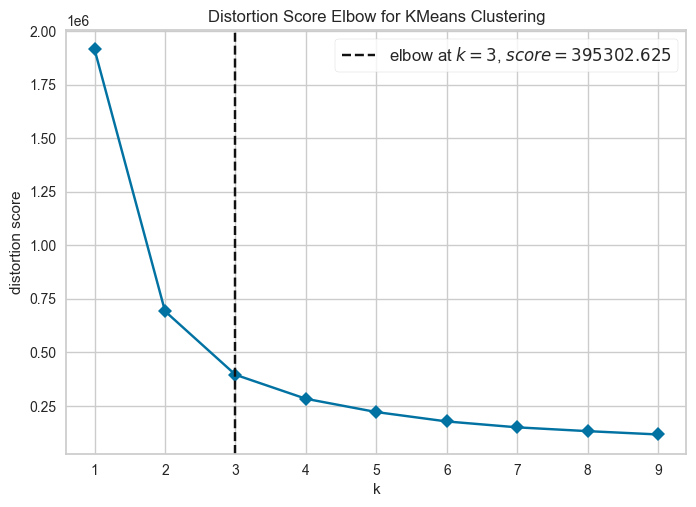

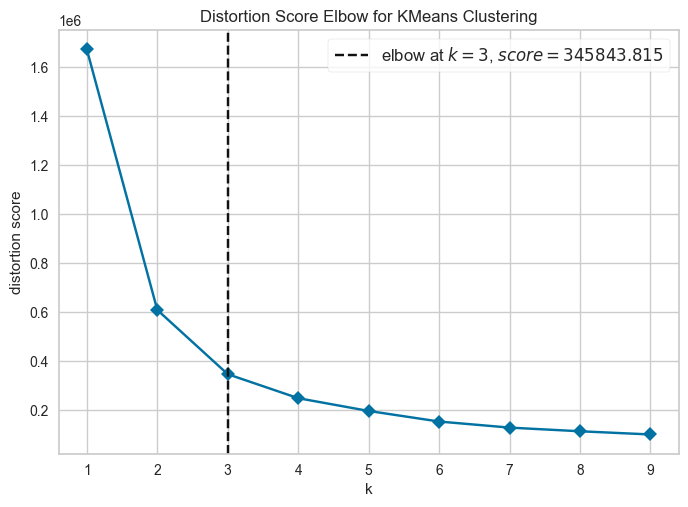

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
# After installing yellowbrick library
from yellowbrick.cluster import KElbowVisualizer

model1 = KMeans() # for the data with duplicates
model2 = KMeans() # for the data without duplicates

# Creating the KElbowVisualizer for the first model
visualizer = KElbowVisualizer(model1, k=(1,10), timings = False)
visualizer.fit(wine_data_v2)
visualizer.show()

# Creating the KElbowVisualizer for the second model
visualizer = KElbowVisualizer(model2, k=(1,10), timings = False)
visualizer.fit(no_duplicates_v2)
visualizer.show()

**Inference :**
- Though the scores are of ~14% difference the number of clusters still remain 3

In [13]:
# Created instances of models for dimensionality reduction using Principal Component Analysis
pca = PCA()
pca2 = PCA()
X = pca.fit_transform(wine_data_v2)
X2 = pca2.fit_transform(no_duplicates_v2)

In [14]:
# Creating models for classification
kmeans = KMeans(n_clusters=3)
label = kmeans.fit_predict(X)
unique_lables = np.unique(label)

kmeans2 = KMeans(n_clusters=3)
label2 = kmeans2.fit_predict(X2)
unique_lables2 = np.unique(label2)

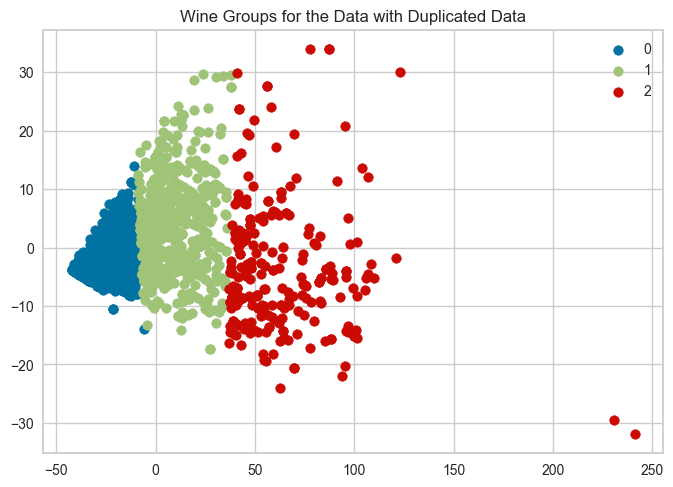

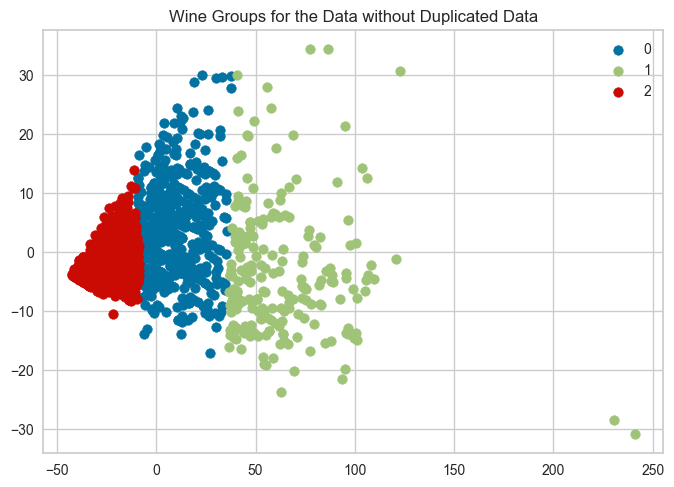

In [15]:
# Visualizing the clusters
for i in unique_lables:
    plt.scatter(X[label==i,0], X[label==i,1], label=i) # the label -- is for the legend 
    
plt.legend()
plt.title('Wine Groups for the Data with Duplicated Data')
plt.show()

for i in unique_lables2:
    plt.scatter(X2[label2==i,0], X2[label2==i,1], label=i)
    
plt.legend()
plt.title('Wine Groups for the Data without Duplicated Data')
plt.show()

**Inference :**
- The two plots look fairly the same.
- The clustering algorithm used different numbers to identify the different clusters on the dataset with duplicated data, hence accounting for the disparity in color in the plots.

**Labelling The Observations**

In [16]:
# Labelling the dataset with duplicates
wine_data_v3 = wine_data.copy()
wine_data_v3['cluster'] = label

# labelling the dataset without duplicates
no_duplicates_v3 = no_duplicates.copy()
no_duplicates_v3['cluster'] = label2

**Reviewing our datasets**

In [17]:
wine_data_v3.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,cluster
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [18]:
no_duplicates_v3.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,cluster
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,0


In [19]:
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [21]:
no_duplicates.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


In [24]:
# resetting the index of the datasets with dropped observations
no_duplicates.reset_index(drop = True, inplace = True)
no_duplicates_v3.reset_index(drop = True, inplace = True)
no_duplicates.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


In [25]:
no_duplicates_v3.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,cluster
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,0
